# Exploring regularization for logistic regression

## Goal

The goal of this lab is to explore the effect of regularization on the coefficients and accuracy of logistic regression models for a toy (wine) dataset

## Set up

In [497]:
import numpy as np
import pandas as pd

np.random.seed(999)

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss, mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'svg'

In [498]:
def normalize(X):
    X = X.copy()
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        if s>0.0:
            X[colname] = (X[colname] - u) / s
        else:
            X[colname] = (X[colname] - u)
    return X

## Load data, create 2-class problem

In [499]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine['y'] = wine.target
df_wine = df_wine[df_wine['y']<2] # Only do 2-class problem {0,1}

X = df_wine.drop('y', axis=1)
y = df_wine['y']
print(f"{len(X)} records for classes {{0,1}} from {len(wine.data)} records")
X.head(2)

130 records for classes {0,1} from 178 records


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0


## Examine coefficients of nonregularized OLS model

**1. Split off validation/test set and train unregularized linear regression model**

Select a seed and random state known to yield poor validation set accuracy (depending on the split, scores will fluctuate, particularly in the presence of outliers.)

In [500]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=999)

In [501]:
lg = LogisticRegression(penalty='none', solver='lbfgs', max_iter=200)
lg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**2. Compare metrics for training and test set**

See [model assessment](https://github.com/parrt/msds621/blob/master/lectures/model-assessment.pdf) for details on the log loss metric, but the score of zero means "no loss" (i.e., perfect score) and it is an unbounded positive loss from there, depending on how bad the model is. Log loss penalizes models that are confident in the wrong answer.

In [502]:
print(f"Accuracy: Train {100*lg.score(X_train, y_train):.0f}%, Test {100*lg.score(X_test, y_test):.0f}%")
y_proba_train = lg.predict_proba(X_train)[:,1]
y_proba_test = lg.predict_proba(X_test)[:,1]
print(f"Log loss: Train {log_loss(y_train, y_proba_train):.2f}, Test {log_loss(y_test, y_proba_test):.2f}")

Accuracy: Train 100%, Test 81%
Log loss: Train 0.00, Test 6.64


**Q.**  What are some possible reasons for the difference in training and testing scores?

<details>
<summary>Solution</summary>
The model could be simply too weak. Our validation set could, by chance, look very different from the training set.  Outliers in the training or validation set can cause such differences.
</details>

**3. Extract $\beta_1, ..., \beta_p$ and count how many are close to 0**

Note: `sum(np.abs(x) < 1e-5)` is a decent way to check for values of `x` close to zero but not necessarily zero.  There is also `numpy.isclose()` but that is too strict (requires numbers to be really close to zero) for this exercise.

In [503]:
lg_beta = lg.coef_[0]
sum(np.abs(lg_beta) < 1e-5) # how many close to 0?

0

<details>
<summary>Solution</summary>
<pre>
lg_beta = lg.coef_[0]
sum(np.abs(lg_beta) < 1e-5) # how many close to 0?
</pre>
</details>

**4. Plot the coefficient index versus the value**

The plot should look something like:

<img src="wine-ols.png" width="200">

The following function is a handy way to plot the coefficients.

In [504]:
def plotbeta(beta, which, yrange=(-20_000, 20_000),fontsize=10, xlabel=True, ylabel=True, tick_format='{x:.1f}', ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(4.5,2.5))
    ax.bar(range(len(beta)),beta)
    if xlabel:
        ax.set_xlabel("Coefficient $\\beta_i$ for $i \\geq 1$", fontsize=fontsize)
    if ylabel:
        ax.set_ylabel("Coefficient value", fontsize=fontsize)
    if yrange is not None:
        ax.set_ylim(*yrange)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(tick_format))
    ax.set_title(f"{which} $\\overline{{\\beta}}$={np.mean(beta):.2f}, $\\sigma(\\beta)$={np.std(beta):.2f}", fontsize=fontsize)

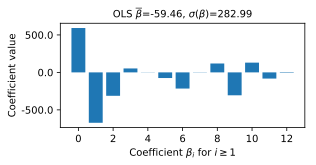

In [505]:
plotbeta(lg_beta, "OLS", yrange=None)
#plt.tight_layout(); plt.savefig("wine-ols.png",dpi=150,bbox_inches=0)

**5. Normalize the variables, retrain, check how many coefficients are close to 0**

In [506]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [507]:
lg = LogisticRegression(penalty='none', solver='lbfgs')
lg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [508]:
lg_beta = lg.coef_[0]
sum(np.abs(lg_beta) < 1e-5) # how many close to 0?

0

**6. Compare the R^2 on training and test set**

In [509]:
print(f"Accuracy: Train {100*lg.score(X_train, y_train):.0f}%, Test {100*lg.score(X_test, y_test):.0f}%")
y_proba_train = lg.predict_proba(X_train)[:,1]
y_proba_test = lg.predict_proba(X_test)[:,1]
print(f"Log loss: Train {log_loss(y_train, y_proba_train):.2f}, Test {log_loss(y_test, y_proba_test):.2f}")

Accuracy: Train 100%, Test 96%
Log loss: Train 0.00, Test 0.05


**Q.**  Without the `max_iter` arg > 100 the logistic regression model for unnormalized data does not converge on a solution. Why does the normalized data converge faster?

<details>
<summary>Solution</summary>
The loss function contours after normalization are more spherical, which can improve the speed of convergence. It's also the case that finite precision floating-point arithmetic for variables with a variety of ranges can lead to erratic loss function contours, leading to imprecise gradients. More on this when we go into gradient descent.
</details>

**Q.**  Why does the test set score improve just by normalizing variables?

<details>
<summary>Solution</summary>
I suspect this has something to do with finite precision arithmetic. When the scale of the variables is the same, computing gradients will be more accurate.
</details>

**7. Plot the coefficient index versus the value again after normalizing variables**

The plot should look something like:

<img src="wine-ols-norm.png" width="200">

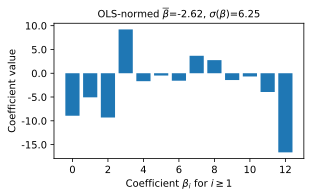

In [510]:
plotbeta(lg_beta, "OLS-normed", yrange=None)
#plt.tight_layout(); plt.savefig("wine-ols-norm.png",dpi=150,bbox_inches=0)

**Q.** Why is the scale of the coefficients different after normalizing the variables?

<details>
<summary>Solution</summary>
The scale the coefficients is a function of the X variable ranges so we would expect normalized variables to  yield smaller coefficients, unless of course the range of the X variables was already small.
</details>

**Q.** Why does the shape of the coefficient graph look different for the normalized data?

<details>
<summary>Solution</summary>
When some coefficients get very large, due to unnormalized data, coefficients with smaller ranges might get less emphasis. But, when all data is in the same range, we get a much more accurate picture of importance of the coefficients.
</details>

## L1 Regularization

In [523]:
"""
sklearn says LogisticRegression arg C is "Inverse of regularization strength...
smaller values specify stronger regularization"
"""
lmbda=.1

In [524]:
lg = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear', max_iter=1000)
lg.fit(X_train, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [525]:
lg_beta = lg.coef_[0]
sum(np.abs(lg_beta) < 1e-5) # how many close to 0?

4

**2. Compare metrics for training and test set**

In [526]:
print(f"Accuracy: Train {100*lg.score(X_train, y_train):.0f}%, Test {100*lg.score(X_test, y_test):.0f}%")
y_proba_train = lg.predict_proba(X_train)[:,1]
y_proba_test = lg.predict_proba(X_test)[:,1]
print(f"Log loss: Train {log_loss(y_train, y_proba_train):.2f}, Test {log_loss(y_test, y_proba_test):.2f}")

Accuracy: Train 100%, Test 96%
Log loss: Train 0.00, Test 0.07


**1. Plot the coefficient index versus the value**

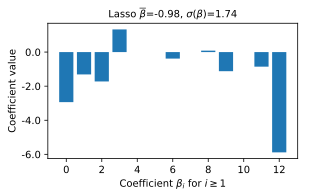

In [527]:
plotbeta(lg_beta, "Lasso", yrange=None, tick_format='{x:.1f}')
#plt.tight_layout(); plt.savefig("wine-l1.png",dpi=150,bbox_inches=0)

**Q.** Compare the L1 regularized coefficients with the normalized OLS coefficients?

<details>
<summary>Solution</summary>
The shape of the coefficients appears to be the same but the scale is smaller for regularized coefficients. More importantly, 4 of the coefficients have gone to zero, which leads to a simpler and more efficient model.
</details>

**Q.** Compare the accuracy of the regularized model to the normalized OLS model?

<details>
<summary>Solution</summary>
The classification error rate, the accuracy, is the same at 96% and the log loss is about the same. Here, the benefit is likely the fact that L1 kills some coefficients.</details>

### Effect of $\lambda$ on regularization and accuracy scores

The goal of the following code snippets is to help you visualize how the $\lambda$ regularization parameter affects model parameters and associated training and testing accuracy. There are a number of important questions to answer following the code snippets.

lambda=1e-05: Zeros   0: Accuracy: Train 100%, Test  96%; Log loss: Train 0.00, Test 0.29
lambda= 0.01: Zeros   4: Accuracy: Train 100%, Test  96%; Log loss: Train 0.00, Test 0.08
lambda=  0.1: Zeros   4: Accuracy: Train 100%, Test  96%; Log loss: Train 0.00, Test 0.08
lambda=    1: Zeros   6: Accuracy: Train 100%, Test  96%; Log loss: Train 0.03, Test 0.11
lambda=   10: Zeros  10: Accuracy: Train  95%, Test  96%; Log loss: Train 0.20, Test 0.25
lambda=  100: Zeros  13: Accuracy: Train  45%, Test  46%; Log loss: Train 0.69, Test 0.69


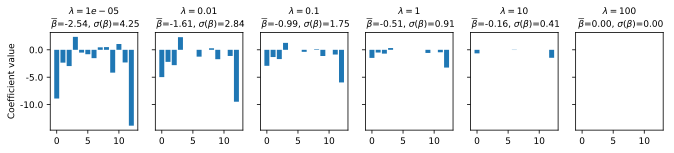

In [516]:
fig,axes = plt.subplots(1,6,figsize=(11,1.8), sharey=True)
for i,lmbda in enumerate([1e-5,.01,.1, 1, 10, 100]):
    lg = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear', max_iter=1000)
    lg.fit(X_train, y_train)
    accur = lg.score(X_train, y_train)
    accurt = lg.score(X_test, y_test)
    y_proba_train = lg.predict_proba(X_train)[:,1]
    y_proba_test = lg.predict_proba(X_test)[:,1]
    print(f"lambda={lmbda:5}: Zeros {sum(np.abs(lg.coef_[0]) < 1e-5):3d}: Accuracy: Train {100*lg.score(X_train, y_train):3.0f}%, Test {100*lg.score(X_test, y_test):3.0f}%; Log loss: Train {log_loss(y_train, y_proba_train):.2f}, Test {log_loss(y_test, y_proba_test):.2f}")
    plotbeta(lg.coef_[0], f"$\\lambda={lmbda}$\n", ax=axes[i], fontsize=9, xlabel=False, ylabel=i==0, yrange=None)

**Q.** Describe what is happening to the L1 coefficients as we increase lambda?

<details>
<summary>Solution</summary>
The average magnitude of the coefficients is changing and they are becoming a tighter group; the standard deviation is shrinking significantly. Many more coefficients are going to zero.
</details>

**Q.** Why does the training accuracy and log loss go down as we increase lambda?

<details>
<summary>Solution</summary>
We are introducing bias, in exchange for increased generality, but clearly you can increase $\lambda$ too much and kill accuracy even for the training set.
</details>

**Q.** What $\lambda$ value would you choose for regularization?

<details>
<summary>Solution</summary>
Based upon the tests above, $\lambda=0.1$ seems a good choice because it gets the lowest log loss on the test set.
</details>

## L2 Regularization

In [528]:
lmbda=0.01

In [529]:
lg = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear', max_iter=1000)
lg.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [530]:
lg_beta = lg.coef_[0]
sum(np.abs(lg_beta) < 1e-5) # how many close to 0?

0

**2. Compare the R^2 on training and test set**

In [531]:
print(f"Accuracy: Train {100*lg.score(X_train, y_train):.0f}%, Test {100*lg.score(X_test, y_test):.0f}%")
y_proba_train = lg.predict_proba(X_train)[:,1]
y_proba_test = lg.predict_proba(X_test)[:,1]
print(f"Log loss: Train {log_loss(y_train, y_proba_train):.2f}, Test {log_loss(y_test, y_proba_test):.2f}")

Accuracy: Train 100%, Test 100%
Log loss: Train 0.00, Test 0.03


**1. Plot the coefficient index versus the value**

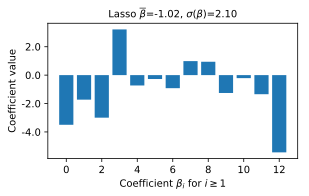

In [532]:
plotbeta(lg_beta, "Lasso", yrange=None, tick_format='{x:.1f}')
#plt.tight_layout(); plt.savefig("wine-l1.png",dpi=150,bbox_inches=0)

### Effect of $\lambda$ on regularization and accuracy scores

The goal of the following code snippets is to help you visualize how the $\lambda$ regularization parameter affects model parameters and associated training and testing accuracy. There are a number of important questions to answer following the code snippets.

lambda=1e-05: Zeros   0: Accuracy: Train 100%, Test  96%; Log loss: Train 0.00, Test 0.04
lambda= 0.01: Zeros   0: Accuracy: Train 100%, Test 100%; Log loss: Train 0.00, Test 0.03
lambda=  0.1: Zeros   0: Accuracy: Train 100%, Test 100%; Log loss: Train 0.01, Test 0.03
lambda=    1: Zeros   0: Accuracy: Train 100%, Test  96%; Log loss: Train 0.04, Test 0.06
lambda=   10: Zeros   0: Accuracy: Train 100%, Test  96%; Log loss: Train 0.14, Test 0.16
lambda=  100: Zeros   0: Accuracy: Train  96%, Test  96%; Log loss: Train 0.37, Test 0.37


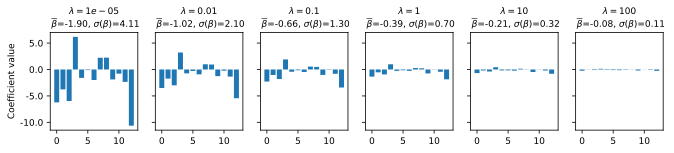

In [533]:
fig,axes = plt.subplots(1,6,figsize=(11,1.8), sharey=True)
for i,lmbda in enumerate([1e-5,.01,.1, 1, 10, 100]):
    lg = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear', max_iter=1000)
    lg.fit(X_train, y_train)
    accur = lg.score(X_train, y_train)
    accurt = lg.score(X_test, y_test)
    y_proba_train = lg.predict_proba(X_train)[:,1]
    y_proba_test = lg.predict_proba(X_test)[:,1]
    print(f"lambda={lmbda:5}: Zeros {sum(np.abs(lg.coef_[0]) < 1e-5):3d}: Accuracy: Train {100*lg.score(X_train, y_train):3.0f}%, Test {100*lg.score(X_test, y_test):3.0f}%; Log loss: Train {log_loss(y_train, y_proba_train):.2f}, Test {log_loss(y_test, y_proba_test):.2f}")
    plotbeta(lg.coef_[0], f"$\\lambda={lmbda}$\n", ax=axes[i], fontsize=9, xlabel=False, ylabel=i==0, yrange=None)

**Q.** Describe what is happening to the L2 coefficients as we increase lambda?

<details>
<summary>Solution</summary>
The average magnitude of the coefficients goes down and they become a tighter group. We don't get any  coefficients going to zero.
</details>

**Q.** Characterize how the magnitudes of L1 and L2 coefficients differ.

<details>
<summary>Solution</summary>
   The L2 coefficients are in general much tighter group than the L1, even as we increase $\lambda$. The L1 regularization drops many of the coefficients to zero for the same value of $\lambda$.
</details>

**Q.**  Which regularization method would you choose for this data set?

<details>
<summary>Solution</summary>
L2 regularization is a clear winner here. Not only is the accuracy on the test set 100%, but the log loss on the test set is smaller than any other technique.
</details>